In [0]:
# !pip install pydicom
# !pip install pyro-ppl

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import pydicom
import h5py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from matplotlib.pyplot import imread
import glob
import os
import random
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import torch.nn as nn
from torchvision.models import alexnet, vgg16, resnet18

%matplotlib inline

import pyro
from pyro.distributions import Normal, Categorical
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# make training behaviour deterministic
# random.seed(1)
# np.random.seed(1)
# torch.manual_seed(1)
# torch.cuda.manual_seed(1)
# torch.backends.cudnn.deterministic = True

In [0]:
# convert pathology values to 0,1, or 2
label_encoder = LabelEncoder()

# Get labels from images
def get_label_dict(df_info, test=False):
    # Just want the 1st part from the image path
    df_info['image_path_base_dir'] = df_info['image file path'].apply(lambda x: x[:x.find('/')])
    bc_callback_indices = df_info[df_info['pathology'] == 'BENIGN_WITHOUT_CALLBACK'].index
    df_info.loc[list(bc_callback_indices), 'pathology'] = 'BENIGN'

#     df_info[df_info['pathlogy_label']]
    if test:
        df_info['pathlogy_label'] = label_encoder.transform(df_info['pathology'])
    else:
        df_info['pathlogy_label'] = label_encoder.fit_transform(df_info['pathology'])
    # key-value => image_path: pathology_value (eg malignant or benign)
    label_dict = pd.Series(df_info['pathlogy_label'].values,index=df_info['image_path_base_dir']).to_dict()
    return label_dict
    
df_train_info = pd.read_csv('/content/drive/My Drive/mass_case_description_train_set.csv')
df_test_info = pd.read_csv('/content/drive/My Drive/mass_case_description_test_set.csv')

train_label_dict = get_label_dict(df_train_info)
test_label_dict = get_label_dict(df_test_info, test=True)

In [0]:
# train_root_path = 'Mass-Full-Images_CBIS-DDSM/Training'
# test_root_path = 'Mass-Full-Images_CBIS-DDSM/Test'
# train_filenames = glob.glob(os.path.join('Mass-Full-Images_CBIS-DDSM/Training', '**', '*.dcm'), recursive=True)
# test_filenames = glob.glob(os.path.join('Mass-Full-Images_CBIS-DDSM/Test', '**', '*.dcm'), recursive=True)

# This has already been run once and is thus commented out
# Don't want to run it multiple times

# with h5py.File('ddsm_data_bi.hdf5', mode='w') as hdf5_file:
#     hdf5_file.create_dataset("train_data", (len(train_filenames), 224, 224), np.float64)
#     hdf5_file.create_dataset("train_labels", (len(train_filenames),), np.int32)
#     hdf5_file.create_dataset("test_data", (len(test_filenames), 224, 224), np.float64)
#     hdf5_file.create_dataset("test_labels", (len(test_filenames),), np.int32)

#     transform = transforms.Compose([transforms.Resize((224, 224)), 
#                                                 transforms.ToTensor(),
#                                                 transforms.Normalize(mean=[0.5], std=[0.5])])

#     for i, fn in enumerate(train_filenames, 0):
#         path_excluding_root_path = fn[len(train_root_path) + 1:]
#         image_path_base_dir = path_excluding_root_path[:path_excluding_root_path.find('\\')]
#         ds = pydicom.read_file(fn)
#         image = Image.fromarray(ds.pixel_array.astype(float))
#         t = transform(image).view(224, 224)
#         label = train_label_dict[image_path_base_dir]
#         hdf5_file["train_data"][i, ...] = t
#         hdf5_file["train_labels"][i] = label
        
#     for i, fn in enumerate(test_filenames, 0):
#         path_excluding_root_path = fn[len(test_root_path) + 1:]
#         image_path_base_dir = path_excluding_root_path[:path_excluding_root_path.find('\\')]
#         ds = pydicom.read_file(fn)
#         image = Image.fromarray(ds.pixel_array.astype(float))
#         t = transform(image).view(224, 224)
#         label = test_label_dict[image_path_base_dir]
#         hdf5_file["test_data"][i, ...] = t
#         hdf5_file["test_labels"][i] = label

# All images (224x224) are now saved in the file
# We will read all images from this file in future

In [0]:
def cuda(xs):
    if torch.cuda.is_available():
        if not isinstance(xs, (list, tuple)):
            return xs.cuda()
        else:
            return [x.cuda() for x in xs]
    else:
        return xs
    
class Dataset_Hdf5(Dataset):

    def __init__(self, path, data_type):
        """ Intialize the dataset
        """
        self.path = path
        self.file = h5py.File(path, 'r')
        self.images = self.file['{}_data'.format(data_type)]
        self.labels = self.file['{}_labels'.format(data_type)]
                
        self.len = self.images.shape[0]
        
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        # unsqueeze adds dimension to image -> converts to 1x224x224 since we don't have rgb
        return cuda(torch.tensor(self.images[index], dtype=torch.float).unsqueeze(0)), \
                cuda(torch.tensor(self.labels[index], dtype=torch.long))

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

# 64 * [224 * 224], 0

In [0]:
ddms_train_loader = torch.utils.data.DataLoader(Dataset_Hdf5('/content/drive/My Drive/ddsm_data_bi_512.hdf5', 'train'), 
                                                batch_size=64, shuffle=True)
ddms_test_loader = torch.utils.data.DataLoader(Dataset_Hdf5('/content/drive/My Drive/ddsm_data_bi_512.hdf5', 'test'), 
                                               batch_size=64, shuffle=True)

In [0]:
# Neural network with 1 hidden layer
class DDMS_NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(DDMS_NN, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.view(-1, self.input_size)
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output
    
class DDMS_NN_Deep(nn.Module):
    def __init__(self):
        super(DDMS_NN_Deep, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.conv4 = nn.Conv2d(32, 32, 5)
        self.fc1 = nn.Linear(32 * 10 * 10, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(self.dropout(F.relu(self.conv1(x))))
        x = self.pool(self.dropout(F.relu(self.conv2(x))))
        x = self.pool(self.dropout(F.relu(self.conv3(x))))
        x = self.pool(self.dropout(F.relu(self.conv4(x))))
        x = x.view(-1, 32 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
alex_net = alexnet(num_classes=2, pretrained=False)
alex_net.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

vgg_net = vgg16(num_classes=2, pretrained=False)
vgg_net.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

res_net = resnet18()
res_net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
res_net.fc = nn.Linear(in_features=512, out_features=2, bias=True)


# all_train_labels = np.array([], dtype='int64')
# for data in ddms_train_loader:
#     _, labels = data
#     labels = labels.numpy()
#     all_train_labels = np.concatenate((all_train_labels, labels))
# label_counts = np.array(np.unique(all_train_labels, return_counts=True))[1]
# class_weights = torch.tensor(label_counts / np.sum(label_counts), dtype=torch.float32)

# ddms_net = DDMS_NN(224*224, 1024, 3) # 3 classes
ddms_net_deep = DDMS_NN_Deep()
# ddms_criterion = nn.CrossEntropyLoss()
# ddms_optimizer = torch.optim.Adam(ddms_net.parameters(), lr=0.01, betas=(0.9, 0.999))

In [0]:
cuda([ddms_net_deep, alex_net, res_net])

[DDMS_NN_Deep(
   (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (dropout): Dropout(p=0.4)
   (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
   (conv4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
   (fc1): Linear(in_features=3200, out_features=120, bias=True)
   (fc2): Linear(in_features=120, out_features=84, bias=True)
   (fc3): Linear(in_features=84, out_features=2, bias=True)
 ), AlexNet(
   (features): Sequential(
     (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
     (1): ReLU(inplace)
     (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (4): ReLU(inplace)
     (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(192, 384, 

In [0]:
ddms_criterion = nn.CrossEntropyLoss()
ddms_optimizer = torch.optim.Adam(ddms_net_deep.parameters(), lr=0.001, betas=(0.5, 0.999))
ddms_optimizer_alex_net = torch.optim.Adam(alex_net.parameters(), lr=0.001, betas=(0.5, 0.999))
ddms_optimizer_vgg_net = torch.optim.Adam(vgg_net.parameters(), lr=0.001, betas=(0.5, 0.999))
ddms_optimizer_res_net = torch.optim.Adam(res_net.parameters(), lr=0.001, betas=(0.5, 0.999))

# ddms_net_deep(iter(ddms_train_loader).next()[0]).shape


In [0]:
def train(net, train_loader, criterion, optimizer, net_name, num_epochs=25):
    net.train()
    train_acc_max = 0
    test_acc_max = 0
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        total = 0
        correct = 0
        
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
#             loss = criterion(outputs.squeeze(1), labels)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
#             predicted = predicted.float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('End of epoch {}, Loss {}'.format(epoch + 1, running_loss / len(train_loader)))
        
        train_acc = correct / total
        test_acc = test(net, ddms_test_loader)
        
        if train_acc > train_acc_max:
            train_acc_max = train_acc
            save_checkpoint(epoch + 1, net, optimizer, train_acc, test_acc, net_name, 'train')
            
        if test_acc > test_acc_max:
            test_acc_max = test_acc
            save_checkpoint(epoch + 1, net, optimizer, train_acc, test_acc, net_name, 'test')

    print('Finished Training')
    
def test(net, test_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
#             predicted = predicted.float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    print('Accuracy of the network on the images: %d %%' % (100 * acc))
    return acc
    
def save_checkpoint(epoch, net, optimizer, train_acc, test_acc, net_name, param):
    checkpoint = {
        'net': net.state_dict(),
        'optimizer': optimizer.state_dict(),
        'train_acc': train_acc,
        'test_acc': test_acc
    }
    torch.save(checkpoint, '/content/drive/My Drive/{}_{}_best.chk'.format(net_name, param))

Try with simple deep net.

In [0]:
train(ddms_net_deep, ddms_train_loader, ddms_criterion, ddms_optimizer, 'deep_net', 30)

End of epoch 1, Loss 362.14788898825645
Accuracy of the network on the images: 51 %
End of epoch 2, Loss 0.7344286143779755
Accuracy of the network on the images: 50 %
End of epoch 3, Loss 0.6471704840660095
Accuracy of the network on the images: 49 %
End of epoch 4, Loss 0.5823244169354439
Accuracy of the network on the images: 54 %
End of epoch 5, Loss 0.5249481126666069
Accuracy of the network on the images: 54 %
End of epoch 6, Loss 0.48273007571697235
Accuracy of the network on the images: 55 %
End of epoch 7, Loss 0.4293503940105438
Accuracy of the network on the images: 53 %
End of epoch 8, Loss 0.3752737700939178
Accuracy of the network on the images: 52 %
End of epoch 9, Loss 0.3354803517460823
Accuracy of the network on the images: 56 %
End of epoch 10, Loss 0.2851590424776077
Accuracy of the network on the images: 57 %
End of epoch 11, Loss 0.2503776606172323
Accuracy of the network on the images: 55 %
End of epoch 12, Loss 0.2103963166475296
Accuracy of the network on the i

In [0]:
test(ddms_net_deep, ddms_test_loader)

Accuracy of the network on the images: 58 %


0.5817174515235457

Try a deeper convnet.

In [0]:
train(alex_net, ddms_train_loader, ddms_criterion, ddms_optimizer_alex_net, 'alex_net', 30)

End of epoch 1, Loss 9912.352517661453
Accuracy of the network on the images: 59 %
End of epoch 2, Loss 0.6914156228303909
Accuracy of the network on the images: 58 %
End of epoch 3, Loss 0.6649431258440017
Accuracy of the network on the images: 60 %
End of epoch 4, Loss 0.6364343017339706
Accuracy of the network on the images: 50 %
End of epoch 5, Loss 0.6710469156503678
Accuracy of the network on the images: 57 %
End of epoch 6, Loss 0.69359592795372
Accuracy of the network on the images: 59 %
End of epoch 7, Loss 0.6272582203149796
Accuracy of the network on the images: 58 %
End of epoch 8, Loss 0.5913879826664925
Accuracy of the network on the images: 50 %
End of epoch 9, Loss 0.6047377854585647
Accuracy of the network on the images: 55 %
End of epoch 10, Loss 28.59727999866009
Accuracy of the network on the images: 40 %
End of epoch 11, Loss 0.7091254025697709
Accuracy of the network on the images: 40 %
End of epoch 12, Loss 0.6908352911472321
Accuracy of the network on the images

In [0]:
test(alex_net, ddms_test_loader)

Accuracy of the network on the images: 59 %


0.5955678670360111

In [0]:
train(vgg_net, ddms_train_loader, ddms_criterion, ddms_optimizer_vgg_net, 'vgg_net', 30)

End of epoch 1, Loss 759316.2570260644
Accuracy of the network on the images: 58 %
End of epoch 2, Loss 0.6916684240102768
Accuracy of the network on the images: 52 %
End of epoch 3, Loss 0.629473552107811
Accuracy of the network on the images: 60 %
End of epoch 4, Loss 0.5832849547266961
Accuracy of the network on the images: 57 %
End of epoch 5, Loss 0.5344417005777359
Accuracy of the network on the images: 50 %
End of epoch 6, Loss 0.5183659628033638
Accuracy of the network on the images: 49 %
End of epoch 7, Loss 0.4541779294610023
Accuracy of the network on the images: 57 %
End of epoch 8, Loss 0.4060332074761391
Accuracy of the network on the images: 58 %
End of epoch 9, Loss 0.39863072633743285
Accuracy of the network on the images: 57 %
End of epoch 10, Loss 0.4002262532711029
Accuracy of the network on the images: 58 %
End of epoch 11, Loss 0.9331123635172844
Accuracy of the network on the images: 45 %
End of epoch 12, Loss 0.7101891010999679
Accuracy of the network on the ima

In [0]:
test(alex_net, ddms_test_loader)

Accuracy of the network on the images: 83 %


0.8302193338748984

In [0]:
train(res_net, ddms_train_loader, ddms_criterion, ddms_optimizer_res_net, 'res_net_2', 30)

End of epoch 1, Loss 0.7206144899129867
Accuracy of the network on the images: 40 %
End of epoch 2, Loss 0.7994544774293899
Accuracy of the network on the images: 59 %
End of epoch 3, Loss 0.69326211810112
Accuracy of the network on the images: 40 %
End of epoch 4, Loss 0.6943872570991516
Accuracy of the network on the images: 40 %
End of epoch 5, Loss 0.6892606735229492
Accuracy of the network on the images: 59 %
End of epoch 6, Loss 0.7860757827758789
Accuracy of the network on the images: 40 %
End of epoch 7, Loss 0.6975642532110214
Accuracy of the network on the images: 59 %
End of epoch 8, Loss 0.6969399929046631
Accuracy of the network on the images: 40 %
End of epoch 9, Loss 0.6946747183799744
Accuracy of the network on the images: 59 %
End of epoch 10, Loss 0.6957039594650268
Accuracy of the network on the images: 40 %
End of epoch 11, Loss 0.6950364768505096
Accuracy of the network on the images: 59 %
End of epoch 12, Loss 0.6941933184862137
Accuracy of the network on the imag

In [0]:
test(res_net, ddms_train_loader)

Accuracy of the network on the images: 65 %


0.6596263200649878

In [0]:
res_net.conv1.weight.shape

torch.Size([64, 1, 7, 7])

In [0]:
# train(alex_net, ddms_train_loader, ddms_criterion, ddms_optimizer, 10)

In [0]:
# test(alex_net, ddms_test_loader)

In [0]:
print(res_net)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
log_softmax = nn.LogSoftmax(dim=1)
net = ddms_net

In [0]:
log_softmax = nn.LogSoftmax(dim=1)
def model_deep_net(x_data, y_data):
    
    conv1w_prior = Normal(loc=torch.zeros_like(ddms_net_deep.conv1.weight).cuda(), scale=torch.ones_like(ddms_net_deep.conv1.weight).cuda())
    conv1b_prior = Normal(loc=torch.zeros_like(ddms_net_deep.conv1.bias).cuda(), scale=torch.ones_like(ddms_net_deep.conv1.bias).cuda())
    
    conv2w_prior = Normal(loc=torch.zeros_like(ddms_net_deep.conv2.weight).cuda(), scale=torch.ones_like(ddms_net_deep.conv2.weight).cuda())
    conv2b_prior = Normal(loc=torch.zeros_like(ddms_net_deep.conv2.bias).cuda(), scale=torch.ones_like(ddms_net_deep.conv2.bias).cuda())
    
    conv3w_prior = Normal(loc=torch.zeros_like(ddms_net_deep.conv3.weight).cuda(), scale=torch.ones_like(ddms_net_deep.conv3.weight).cuda())
    conv3b_prior = Normal(loc=torch.zeros_like(ddms_net_deep.conv3.bias).cuda(), scale=torch.ones_like(ddms_net_deep.conv3.bias).cuda())
    
    conv4w_prior = Normal(loc=torch.zeros_like(ddms_net_deep.conv4.weight).cuda(), scale=torch.ones_like(ddms_net_deep.conv4.weight).cuda())
    conv4b_prior = Normal(loc=torch.zeros_like(ddms_net_deep.conv4.bias).cuda(), scale=torch.ones_like(ddms_net_deep.conv4.bias).cuda())
    
    fc1w_prior = Normal(loc=torch.zeros_like(ddms_net_deep.fc1.weight).cuda(), scale=torch.ones_like(ddms_net_deep.fc1.weight).cuda())
    fc1b_prior = Normal(loc=torch.zeros_like(ddms_net_deep.fc1.bias).cuda(), scale=torch.ones_like(ddms_net_deep.fc1.bias).cuda())
    
    fc2w_prior = Normal(loc=torch.zeros_like(ddms_net_deep.fc2.weight).cuda(), scale=torch.ones_like(ddms_net_deep.fc2.weight).cuda())
    fc2b_prior = Normal(loc=torch.zeros_like(ddms_net_deep.fc2.bias).cuda(), scale=torch.ones_like(ddms_net_deep.fc2.bias).cuda())
    
    fc3w_prior = Normal(loc=torch.zeros_like(ddms_net_deep.fc3.weight).cuda(), scale=torch.ones_like(ddms_net_deep.fc3.weight).cuda())
    fc3b_prior = Normal(loc=torch.zeros_like(ddms_net_deep.fc3.bias).cuda(), scale=torch.ones_like(ddms_net_deep.fc3.bias).cuda())

    
    priors = {'conv1.weight': conv1w_prior, 
              'conv1.bias': conv1b_prior,  
              'conv2.weight': conv2w_prior, 
              'conv2.bias': conv2b_prior, 
              'conv3.weight': conv3w_prior, 
              'conv3.bias': conv3b_prior, 
              'conv4.weight': conv4w_prior, 
              'conv4.bias': conv4b_prior, 
              'fc1.weight': fc1w_prior, 
              'fc1.bias': fc1b_prior, 
              'fc2.weight': fc2w_prior, 
              'fc2.bias': fc2b_prior, 
              'fc3.weight': fc3w_prior, 
              'fc3.bias': fc3b_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", ddms_net_deep, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [0]:
softplus = torch.nn.Softplus()

def guide_deep_net(x_data, y_data):
    # First conv layer weight distribution priors
    conv1w_mu = torch.randn_like(ddms_net_deep.conv1.weight).cuda()
    conv1w_sigma = torch.randn_like(ddms_net_deep.conv1.weight).cuda()
    conv1w_mu_param = pyro.param("conv1w_mu", conv1w_mu)
    conv1w_sigma_param = softplus(pyro.param("conv1w_sigma", conv1w_sigma))
    conv1w_prior = Normal(loc=conv1w_mu_param, scale=conv1w_sigma_param)
    # First conv layer bias distribution priors
    conv1b_mu = torch.randn_like(ddms_net_deep.conv1.bias).cuda()
    conv1b_sigma = torch.randn_like(ddms_net_deep.conv1.bias).cuda()
    conv1b_mu_param = pyro.param("conv1b_mu", conv1b_mu)
    conv1b_sigma_param = softplus(pyro.param("conv1b_sigma", conv1b_sigma))
    conv1b_prior = Normal(loc=conv1b_mu_param, scale=conv1b_sigma_param)
    # Second conv layer weight distribution priors
    conv2w_mu = torch.randn_like(ddms_net_deep.conv2.weight).cuda()
    conv2w_sigma = torch.randn_like(ddms_net_deep.conv2.weight).cuda()
    conv2w_mu_param = pyro.param("conv2w_mu", conv2w_mu)
    conv2w_sigma_param = softplus(pyro.param("conv2w_sigma", conv2w_sigma))
    conv2w_prior = Normal(loc=conv2w_mu_param, scale=conv2w_sigma_param)
    # Second conv layer bias distribution priors
    conv2b_mu = torch.randn_like(ddms_net_deep.conv2.bias).cuda()
    conv2b_sigma = torch.randn_like(ddms_net_deep.conv2.bias).cuda()
    conv2b_mu_param = pyro.param("conv2b_mu", conv2b_mu)
    conv2b_sigma_param = softplus(pyro.param("conv2b_sigma", conv2b_sigma))
    conv2b_prior = Normal(loc=conv2b_mu_param, scale=conv2b_sigma_param)
    # Third conv layer weight distribution priors
    conv3w_mu = torch.randn_like(ddms_net_deep.conv3.weight).cuda()
    conv3w_sigma = torch.randn_like(ddms_net_deep.conv3.weight).cuda()
    conv3w_mu_param = pyro.param("conv3w_mu", conv3w_mu)
    conv3w_sigma_param = softplus(pyro.param("conv3w_sigma", conv3w_sigma))
    conv3w_prior = Normal(loc=conv3w_mu_param, scale=conv3w_sigma_param)
    # Third conv layer bias distribution priors
    conv3b_mu = torch.randn_like(ddms_net_deep.conv3.bias).cuda()
    conv3b_sigma = torch.randn_like(ddms_net_deep.conv3.bias).cuda()
    conv3b_mu_param = pyro.param("conv3b_mu", conv3b_mu)
    conv3b_sigma_param = softplus(pyro.param("conv3b_sigma", conv3b_sigma))
    conv3b_prior = Normal(loc=conv3b_mu_param, scale=conv3b_sigma_param)
    # First conv layer weight distribution priors
    conv4w_mu = torch.randn_like(ddms_net_deep.conv4.weight).cuda()
    conv4w_sigma = torch.randn_like(ddms_net_deep.conv4.weight).cuda()
    conv4w_mu_param = pyro.param("conv4w_mu", conv4w_mu)
    conv4w_sigma_param = softplus(pyro.param("conv4w_sigma", conv4w_sigma))
    conv4w_prior = Normal(loc=conv4w_mu_param, scale=conv4w_sigma_param)
    # First conv layer bias distribution priors
    conv4b_mu = torch.randn_like(ddms_net_deep.conv4.bias).cuda()
    conv4b_sigma = torch.randn_like(ddms_net_deep.conv4.bias).cuda()
    conv4b_mu_param = pyro.param("conv4b_mu", conv4b_mu)
    conv4b_sigma_param = softplus(pyro.param("conv4b_sigma", conv4b_sigma))
    conv4b_prior = Normal(loc=conv4b_mu_param, scale=conv4b_sigma_param)
    # First fully connected layer weight distribution priors
    fc1w_mu = torch.randn_like(ddms_net_deep.fc1.weight).cuda()
    fc1w_sigma = torch.randn_like(ddms_net_deep.fc1.weight).cuda()
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First fully connected layer bias distribution priors
    fc1b_mu = torch.randn_like(ddms_net_deep.fc1.bias).cuda()
    fc1b_sigma = torch.randn_like(ddms_net_deep.fc1.bias).cuda()
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Second fully connected layer weight distribution priors
    fc2w_mu = torch.randn_like(ddms_net_deep.fc2.weight).cuda()
    fc2w_sigma = torch.randn_like(ddms_net_deep.fc2.weight).cuda()
    fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
    fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", fc2w_sigma))
    fc2w_prior = Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param)
    # Second fully connected layer bias distribution priors
    fc2b_mu = torch.randn_like(ddms_net_deep.fc2.bias).cuda()
    fc2b_sigma = torch.randn_like(ddms_net_deep.fc2.bias).cuda()
    fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu)
    fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", fc2b_sigma))
    fc2b_prior = Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param)
    # Third fully connected layer weight distribution priors
    fc3w_mu = torch.randn_like(ddms_net_deep.fc3.weight).cuda()
    fc3w_sigma = torch.randn_like(ddms_net_deep.fc3.weight).cuda()
    fc3w_mu_param = pyro.param("fc3w_mu", fc3w_mu)
    fc3w_sigma_param = softplus(pyro.param("fc3w_sigma", fc3w_sigma))
    fc3w_prior = Normal(loc=fc3w_mu_param, scale=fc3w_sigma_param)
    # Third fully connected layer bias distribution priors
    fc3b_mu = torch.randn_like(ddms_net_deep.fc3.bias).cuda()
    fc3b_sigma = torch.randn_like(ddms_net_deep.fc3.bias).cuda()
    fc3b_mu_param = pyro.param("fc3b_mu", fc3b_mu)
    fc3b_sigma_param = softplus(pyro.param("fc3b_sigma", fc3b_sigma))
    fc3b_prior = Normal(loc=fc3b_mu_param, scale=fc3b_sigma_param)
    
    priors = {'conv1.weight': conv1w_prior, 
              'conv1.bias': conv1b_prior,  
              'conv2.weight': conv2w_prior, 
              'conv2.bias': conv2b_prior, 
              'conv3.weight': conv3w_prior, 
              'conv3.bias': conv3b_prior, 
              'conv4.weight': conv4w_prior, 
              'conv4.bias': conv4b_prior, 
              'fc1.weight': fc1w_prior, 
              'fc1.bias': fc1b_prior, 
              'fc2.weight': fc2w_prior, 
              'fc2.bias': fc2b_prior, 
              'fc3.weight': fc3w_prior, 
              'fc3.bias': fc3b_prior}
    
    lifted_module = pyro.random_module("module", ddms_net_deep, priors)
    
    return lifted_module()

In [0]:
log_softmax = nn.LogSoftmax(dim=1)

def model_res_net(x_data, y_data):
    
    conv1w_prior = Normal(loc=torch.zeros_like(res_net.conv1.weight).cuda(), scale=torch.ones_like(res_net.conv1.weight).cuda())
    
    bnw_prior = Normal(loc=torch.zeros_like(res_net.bn1.weight).cuda(), scale=torch.ones_like(res_net.bn1.weight).cuda())
    bnb_prior = Normal(loc=torch.zeros_like(res_net.bn1.bias).cuda(), scale=torch.ones_like(res_net.bn1.bias).cuda())
    
    layer1_0_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[0].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer1[0].conv1.weight).cuda())
    layer1_0_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[0].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer1[0].bn1.weight).cuda())
    layer1_0_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer1[0].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer1[0].bn1.bias).cuda())
    layer1_0_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[0].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer1[0].conv2.weight).cuda())
    layer1_0_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[0].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer1[0].bn2.weight).cuda())
    layer1_0_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer1[0].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer1[0].bn2.bias).cuda())
    layer1_1_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[1].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer1[1].conv1.weight).cuda())
    layer1_1_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[1].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer1[1].bn1.weight).cuda())
    layer1_1_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer1[1].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer1[1].bn1.bias).cuda())
    layer1_1_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[1].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer1[1].conv2.weight).cuda())
    layer1_1_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[1].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer1[1].bn2.weight).cuda())
    layer1_1_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer1[1].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer1[1].bn2.bias).cuda())
    
    layer2_0_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer2[0].conv1.weight).cuda())
    layer2_0_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer2[0].bn1.weight).cuda())
    layer2_0_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer2[0].bn1.bias).cuda())
    layer2_0_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer2[0].conv2.weight).cuda())
    layer2_0_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer2[0].bn2.weight).cuda())
    layer2_0_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer2[0].bn2.bias).cuda())
    layer2_0_downsample_0_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].downsample[0].weight).cuda(), scale=torch.ones_like(res_net.layer2[0].downsample[0].weight).cuda())   
    layer2_0_downsample_1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].downsample[1].weight).cuda(), scale=torch.ones_like(res_net.layer2[0].downsample[1].weight).cuda())   
    layer2_0_downsample_1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].downsample[1].bias).cuda(), scale=torch.ones_like(res_net.layer2[0].downsample[1].bias).cuda())   
    layer2_1_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[1].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer2[1].conv1.weight).cuda())
    layer2_1_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[1].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer2[1].bn1.weight).cuda())
    layer2_1_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer2[1].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer2[1].bn1.bias).cuda())
    layer2_1_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[1].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer2[1].conv2.weight).cuda())
    layer2_1_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[1].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer2[1].bn2.weight).cuda())
    layer2_1_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer2[1].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer2[1].bn2.bias).cuda())
    
    layer3_0_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer3[0].conv1.weight).cuda())
    layer3_0_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer3[0].bn1.weight).cuda())
    layer3_0_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer3[0].bn1.bias).cuda())
    layer3_0_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer3[0].conv2.weight).cuda())
    layer3_0_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer3[0].bn2.weight).cuda())
    layer3_0_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer3[0].bn2.bias).cuda())
    layer3_0_downsample_0_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].downsample[0].weight).cuda(), scale=torch.ones_like(res_net.layer3[0].downsample[0].weight).cuda())   
    layer3_0_downsample_1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].downsample[1].weight).cuda(), scale=torch.ones_like(res_net.layer3[0].downsample[1].weight).cuda())   
    layer3_0_downsample_1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].downsample[1].bias).cuda(), scale=torch.ones_like(res_net.layer3[0].downsample[1].bias).cuda())   
    layer3_1_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[1].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer3[1].conv1.weight).cuda())
    layer3_1_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[1].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer3[1].bn1.weight).cuda())
    layer3_1_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer3[1].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer3[1].bn1.bias).cuda())
    layer3_1_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[1].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer3[1].conv2.weight).cuda())
    layer3_1_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[1].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer3[1].bn2.weight).cuda())
    layer3_1_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer3[1].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer3[1].bn2.bias).cuda())
    
    layer4_0_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer4[0].conv1.weight).cuda())
    layer4_0_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer4[0].bn1.weight).cuda())
    layer4_0_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer4[0].bn1.bias).cuda())
    layer4_0_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer4[0].conv2.weight).cuda())
    layer4_0_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer4[0].bn2.weight).cuda())
    layer4_0_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer4[0].bn2.bias).cuda())
    layer4_0_downsample_0_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].downsample[0].weight).cuda(), scale=torch.ones_like(res_net.layer4[0].downsample[0].weight).cuda())   
    layer4_0_downsample_1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].downsample[1].weight).cuda(), scale=torch.ones_like(res_net.layer4[0].downsample[1].weight).cuda())   
    layer4_0_downsample_1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].downsample[1].bias).cuda(), scale=torch.ones_like(res_net.layer4[0].downsample[1].bias).cuda())   
    layer4_1_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[1].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer4[1].conv1.weight).cuda())
    layer4_1_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[1].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer4[1].bn1.weight).cuda())
    layer4_1_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer4[1].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer4[1].bn1.bias).cuda())
    layer4_1_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[1].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer4[1].conv2.weight).cuda())
    layer4_1_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[1].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer4[1].bn2.weight).cuda())
    layer4_1_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer4[1].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer4[1].bn2.bias).cuda())
    
    fcw_prior = Normal(loc=torch.zeros_like(res_net.fc.weight).cuda(), scale=torch.ones_like(res_net.fc.weight).cuda())
    fcb_prior = Normal(loc=torch.zeros_like(res_net.fc.bias).cuda(), scale=torch.ones_like(res_net.fc.bias).cuda())



    priors = {'conv1.weight': conv1w_prior, 
              'bn1.weight': bnw_prior,  
              'bn1.bias': bnb_prior, 
              'layer1.0.conv1.weight': layer1_0_conv1_weight_prior, 
              'layer1.0.bn1.weight': layer1_0_bn1_weight_prior, 
              'layer1.0.bn1.bias': layer1_0_bn1_bias_prior, 
              'layer1.0.conv2.weight': layer1_0_conv2_weight_prior, 
              'layer1.0.bn2.weight': layer1_0_bn2_weight_prior, 
              'layer1.0.bn2.bias': layer1_0_bn2_bias_prior, 
              'layer1.1.conv1.weight': layer1_1_conv1_weight_prior, 
              'layer1.1.bn1.weight': layer1_1_bn1_weight_prior, 
              'layer1.1.bn1.bias': layer1_1_bn1_bias_prior, 
              'layer1.1.conv2.weight': layer1_1_conv2_weight_prior, 
              'layer1.1.bn2.weight': layer1_1_bn2_weight_prior, 
              'layer1.1.bn2.bias': layer1_1_bn2_bias_prior, 
              'layer2.0.conv1.weight': layer2_0_conv1_weight_prior, 
              'layer2.0.bn1.weight': layer2_0_bn1_weight_prior, 
              'layer2.0.bn1.bias': layer2_0_bn1_bias_prior, 
              'layer2.0.conv2.weight': layer2_0_conv2_weight_prior, 
              'layer2.0.bn2.weight': layer2_0_bn2_weight_prior, 
              'layer2.0.bn2.bias': layer2_0_bn2_bias_prior, 
              'layer2.0.downsample.0.weight': layer2_0_downsample_0_weight_prior,
              'layer2.0.downsample.1.weight': layer2_0_downsample_1_weight_prior,
              'layer2.0.downsample.1.bias': layer2_0_downsample_1_bias_prior,
              'layer2.1.conv1.weight': layer2_1_conv1_weight_prior, 
              'layer2.1.bn1.weight': layer2_1_bn1_weight_prior, 
              'layer2.1.bn1.bias': layer2_1_bn1_bias_prior, 
              'layer2.1.conv2.weight': layer2_1_conv2_weight_prior, 
              'layer2.1.bn2.weight': layer2_1_bn2_weight_prior, 
              'layer2.1.bn2.bias': layer2_1_bn2_bias_prior, 
              'layer3.0.conv1.weight': layer3_0_conv1_weight_prior, 
              'layer3.0.bn1.weight': layer3_0_bn1_weight_prior, 
              'layer3.0.bn1.bias': layer3_0_bn1_bias_prior, 
              'layer3.0.conv2.weight': layer3_0_conv2_weight_prior, 
              'layer3.0.bn2.weight': layer3_0_bn2_weight_prior, 
              'layer3.0.bn2.bias': layer3_0_bn2_bias_prior, 
              'layer3.0.downsample.0.weight': layer3_0_downsample_0_weight_prior,
              'layer3.0.downsample.1.weight': layer3_0_downsample_1_weight_prior,
              'layer3.0.downsample.1.bias': layer3_0_downsample_1_bias_prior,
              'layer3.1.conv1.weight': layer3_1_conv1_weight_prior, 
              'layer3.1.bn1.weight': layer3_1_bn1_weight_prior, 
              'layer3.1.bn1.bias': layer3_1_bn1_bias_prior, 
              'layer3.1.conv2.weight': layer3_1_conv2_weight_prior, 
              'layer3.1.bn2.weight': layer3_1_bn2_weight_prior, 
              'layer3.1.bn2.bias': layer3_1_bn2_bias_prior,
              'layer4.0.conv1.weight': layer4_0_conv1_weight_prior, 
              'layer4.0.bn1.weight': layer4_0_bn1_weight_prior, 
              'layer4.0.bn1.bias': layer4_0_bn1_bias_prior, 
              'layer4.0.conv2.weight': layer4_0_conv2_weight_prior, 
              'layer4.0.bn2.weight': layer4_0_bn2_weight_prior, 
              'layer4.0.bn2.bias': layer4_0_bn2_bias_prior, 
              'layer4.0.downsample.0.weight': layer4_0_downsample_0_weight_prior,
              'layer4.0.downsample.1.weight': layer4_0_downsample_1_weight_prior,
              'layer4.0.downsample.1.bias': layer4_0_downsample_1_bias_prior,
              'layer4.1.conv1.weight': layer4_1_conv1_weight_prior, 
              'layer4.1.bn1.weight': layer4_1_bn1_weight_prior, 
              'layer4.1.bn1.bias': layer4_1_bn1_bias_prior, 
              'layer4.1.conv2.weight': layer4_1_conv2_weight_prior, 
              'layer4.1.bn2.weight': layer4_1_bn2_weight_prior, 
              'layer4.1.bn2.bias': layer4_1_bn2_bias_prior,
              'fc.weight': fcw_prior,
              'fc.bias': fcb_prior }
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", res_net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [0]:
softplus = torch.nn.Softplus()

def guide_res_net(x_data, y_data):
    conv1w_prior = Normal(loc=torch.zeros_like(res_net.conv1.weight).cuda(), scale=torch.ones_like(res_net.conv1.weight).cuda())
    
    bnw_prior = Normal(loc=torch.zeros_like(res_net.bn1.weight).cuda(), scale=torch.ones_like(res_net.bn1.weight).cuda())
    bnb_prior = Normal(loc=torch.zeros_like(res_net.bn1.bias).cuda(), scale=torch.ones_like(res_net.bn1.bias).cuda())
    
    layer1_0_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[0].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer1[0].conv1.weight).cuda())
    layer1_0_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[0].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer1[0].bn1.weight).cuda())
    layer1_0_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer1[0].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer1[0].bn1.bias).cuda())
    layer1_0_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[0].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer1[0].conv2.weight).cuda())
    layer1_0_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[0].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer1[0].bn2.weight).cuda())
    layer1_0_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer1[0].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer1[0].bn2.bias).cuda())
    layer1_1_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[1].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer1[1].conv1.weight).cuda())
    layer1_1_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[1].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer1[1].bn1.weight).cuda())
    layer1_1_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer1[1].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer1[1].bn1.bias).cuda())
    layer1_1_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[1].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer1[1].conv2.weight).cuda())
    layer1_1_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer1[1].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer1[1].bn2.weight).cuda())
    layer1_1_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer1[1].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer1[1].bn2.bias).cuda())
    
    layer2_0_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer2[0].conv1.weight).cuda())
    layer2_0_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer2[0].bn1.weight).cuda())
    layer2_0_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer2[0].bn1.bias).cuda())
    layer2_0_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer2[0].conv2.weight).cuda())
    layer2_0_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer2[0].bn2.weight).cuda())
    layer2_0_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer2[0].bn2.bias).cuda())
    layer2_0_downsample_0_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].downsample[0].weight).cuda(), scale=torch.ones_like(res_net.layer2[0].downsample[0].weight).cuda())   
    layer2_0_downsample_1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].downsample[1].weight).cuda(), scale=torch.ones_like(res_net.layer2[0].downsample[1].weight).cuda())   
    layer2_0_downsample_1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer2[0].downsample[1].bias).cuda(), scale=torch.ones_like(res_net.layer2[0].downsample[1].bias).cuda())   
    layer2_1_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[1].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer2[1].conv1.weight).cuda())
    layer2_1_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[1].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer2[1].bn1.weight).cuda())
    layer2_1_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer2[1].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer2[1].bn1.bias).cuda())
    layer2_1_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[1].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer2[1].conv2.weight).cuda())
    layer2_1_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer2[1].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer2[1].bn2.weight).cuda())
    layer2_1_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer2[1].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer2[1].bn2.bias).cuda())
    
    layer3_0_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer3[0].conv1.weight).cuda())
    layer3_0_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer3[0].bn1.weight).cuda())
    layer3_0_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer3[0].bn1.bias).cuda())
    layer3_0_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer3[0].conv2.weight).cuda())
    layer3_0_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer3[0].bn2.weight).cuda())
    layer3_0_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer3[0].bn2.bias).cuda())
    layer3_0_downsample_0_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].downsample[0].weight).cuda(), scale=torch.ones_like(res_net.layer3[0].downsample[0].weight).cuda())   
    layer3_0_downsample_1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].downsample[1].weight).cuda(), scale=torch.ones_like(res_net.layer3[0].downsample[1].weight).cuda())   
    layer3_0_downsample_1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer3[0].downsample[1].bias).cuda(), scale=torch.ones_like(res_net.layer3[0].downsample[1].bias).cuda())   
    layer3_1_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[1].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer3[1].conv1.weight).cuda())
    layer3_1_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[1].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer3[1].bn1.weight).cuda())
    layer3_1_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer3[1].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer3[1].bn1.bias).cuda())
    layer3_1_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[1].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer3[1].conv2.weight).cuda())
    layer3_1_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer3[1].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer3[1].bn2.weight).cuda())
    layer3_1_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer3[1].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer3[1].bn2.bias).cuda())
    
    layer4_0_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer4[0].conv1.weight).cuda())
    layer4_0_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer4[0].bn1.weight).cuda())
    layer4_0_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer4[0].bn1.bias).cuda())
    layer4_0_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer4[0].conv2.weight).cuda())
    layer4_0_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer4[0].bn2.weight).cuda())
    layer4_0_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer4[0].bn2.bias).cuda())
    layer4_0_downsample_0_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].downsample[0].weight).cuda(), scale=torch.ones_like(res_net.layer4[0].downsample[0].weight).cuda())   
    layer4_0_downsample_1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].downsample[1].weight).cuda(), scale=torch.ones_like(res_net.layer4[0].downsample[1].weight).cuda())   
    layer4_0_downsample_1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer4[0].downsample[1].bias).cuda(), scale=torch.ones_like(res_net.layer4[0].downsample[1].bias).cuda())   
    layer4_1_conv1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[1].conv1.weight).cuda(), scale=torch.ones_like(res_net.layer4[1].conv1.weight).cuda())
    layer4_1_bn1_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[1].bn1.weight).cuda(), scale=torch.ones_like(res_net.layer4[1].bn1.weight).cuda())
    layer4_1_bn1_bias_prior = Normal(loc=torch.zeros_like(res_net.layer4[1].bn1.bias).cuda(), scale=torch.ones_like(res_net.layer4[1].bn1.bias).cuda())
    layer4_1_conv2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[1].conv2.weight).cuda(), scale=torch.ones_like(res_net.layer4[1].conv2.weight).cuda())
    layer4_1_bn2_weight_prior = Normal(loc=torch.zeros_like(res_net.layer4[1].bn2.weight).cuda(), scale=torch.ones_like(res_net.layer4[1].bn2.weight).cuda())
    layer4_1_bn2_bias_prior = Normal(loc=torch.zeros_like(res_net.layer4[1].bn2.bias).cuda(), scale=torch.ones_like(res_net.layer4[1].bn2.bias).cuda())
    
    fcw_prior = Normal(loc=torch.zeros_like(res_net.fc.weight).cuda(), scale=torch.ones_like(res_net.fc.weight).cuda())
    fcb_prior = Normal(loc=torch.zeros_like(res_net.fc.bias).cuda(), scale=torch.ones_like(res_net.fc.bias).cuda())



    priors = {'conv1.weight': conv1w_prior, 
              'bn1.weight': bnw_prior,  
              'bn1.bias': bnb_prior, 
              'layer1.0.conv1.weight': layer1_0_conv1_weight_prior, 
              'layer1.0.bn1.weight': layer1_0_bn1_weight_prior, 
              'layer1.0.bn1.bias': layer1_0_bn1_bias_prior, 
              'layer1.0.conv2.weight': layer1_0_conv2_weight_prior, 
              'layer1.0.bn2.weight': layer1_0_bn2_weight_prior, 
              'layer1.0.bn2.bias': layer1_0_bn2_bias_prior, 
              'layer1.1.conv1.weight': layer1_1_conv1_weight_prior, 
              'layer1.1.bn1.weight': layer1_1_bn1_weight_prior, 
              'layer1.1.bn1.bias': layer1_1_bn1_bias_prior, 
              'layer1.1.conv2.weight': layer1_1_conv2_weight_prior, 
              'layer1.1.bn2.weight': layer1_1_bn2_weight_prior, 
              'layer1.1.bn2.bias': layer1_1_bn2_bias_prior, 
              'layer2.0.conv1.weight': layer2_0_conv1_weight_prior, 
              'layer2.0.bn1.weight': layer2_0_bn1_weight_prior, 
              'layer2.0.bn1.bias': layer2_0_bn1_bias_prior, 
              'layer2.0.conv2.weight': layer2_0_conv2_weight_prior, 
              'layer2.0.bn2.weight': layer2_0_bn2_weight_prior, 
              'layer2.0.bn2.bias': layer2_0_bn2_bias_prior, 
              'layer2.0.downsample.0.weight': layer2_0_downsample_0_weight_prior,
              'layer2.0.downsample.1.weight': layer2_0_downsample_1_weight_prior,
              'layer2.0.downsample.1.bias': layer2_0_downsample_1_bias_prior,
              'layer2.1.conv1.weight': layer2_1_conv1_weight_prior, 
              'layer2.1.bn1.weight': layer2_1_bn1_weight_prior, 
              'layer2.1.bn1.bias': layer2_1_bn1_bias_prior, 
              'layer2.1.conv2.weight': layer2_1_conv2_weight_prior, 
              'layer2.1.bn2.weight': layer2_1_bn2_weight_prior, 
              'layer2.1.bn2.bias': layer2_1_bn2_bias_prior, 
              'layer3.0.conv1.weight': layer3_0_conv1_weight_prior, 
              'layer3.0.bn1.weight': layer3_0_bn1_weight_prior, 
              'layer3.0.bn1.bias': layer3_0_bn1_bias_prior, 
              'layer3.0.conv2.weight': layer3_0_conv2_weight_prior, 
              'layer3.0.bn2.weight': layer3_0_bn2_weight_prior, 
              'layer3.0.bn2.bias': layer3_0_bn2_bias_prior, 
              'layer3.0.downsample.0.weight': layer3_0_downsample_0_weight_prior,
              'layer3.0.downsample.1.weight': layer3_0_downsample_1_weight_prior,
              'layer3.0.downsample.1.bias': layer3_0_downsample_1_bias_prior,
              'layer3.1.conv1.weight': layer3_1_conv1_weight_prior, 
              'layer3.1.bn1.weight': layer3_1_bn1_weight_prior, 
              'layer3.1.bn1.bias': layer3_1_bn1_bias_prior, 
              'layer3.1.conv2.weight': layer3_1_conv2_weight_prior, 
              'layer3.1.bn2.weight': layer3_1_bn2_weight_prior, 
              'layer3.1.bn2.bias': layer3_1_bn2_bias_prior,
              'layer4.0.conv1.weight': layer4_0_conv1_weight_prior, 
              'layer4.0.bn1.weight': layer4_0_bn1_weight_prior, 
              'layer4.0.bn1.bias': layer4_0_bn1_bias_prior, 
              'layer4.0.conv2.weight': layer4_0_conv2_weight_prior, 
              'layer4.0.bn2.weight': layer4_0_bn2_weight_prior, 
              'layer4.0.bn2.bias': layer4_0_bn2_bias_prior, 
              'layer4.0.downsample.0.weight': layer4_0_downsample_0_weight_prior,
              'layer4.0.downsample.1.weight': layer4_0_downsample_1_weight_prior,
              'layer4.0.downsample.1.bias': layer4_0_downsample_1_bias_prior,
              'layer4.1.conv1.weight': layer4_1_conv1_weight_prior, 
              'layer4.1.bn1.weight': layer4_1_bn1_weight_prior, 
              'layer4.1.bn1.bias': layer4_1_bn1_bias_prior, 
              'layer4.1.conv2.weight': layer4_1_conv2_weight_prior, 
              'layer4.1.bn2.weight': layer4_1_bn2_weight_prior, 
              'layer4.1.bn2.bias': layer4_1_bn2_bias_prior,
              'fc.weight': fcw_prior,
              'fc.bias': fcb_prior }

    lifted_module = pyro.random_module("module", res_net, priors)
    return lifted_module()

In [0]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [0]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [0]:
optim = Adam({"lr": 0.001})
svi = SVI(model_res_net, guide_res_net, optim, loss=Trace_ELBO())

In [0]:
num_iterations = 30
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(ddms_train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0], data[1])
    normalizer_train = len(ddms_train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

Epoch  0  Loss  8.897866934615588e+22
Epoch  1  Loss  1.0516766636689972e+23
Epoch  2  Loss  7.635949826942333e+22
Epoch  3  Loss  8.382052458298461e+22
Epoch  4  Loss  1.3317616821707206e+23
Epoch  5  Loss  6.885387810990238e+22
Epoch  6  Loss  9.957872006808475e+22
Epoch  7  Loss  6.035181751600129e+22
Epoch  8  Loss  1.6652748162952068e+23
Epoch  9  Loss  4.769333092914398e+22
Epoch  10  Loss  6.92443762702943e+22
Epoch  11  Loss  1.1676692742356249e+23
Epoch  12  Loss  1.0501359499686031e+23
Epoch  13  Loss  1.0141682819061411e+23
Epoch  14  Loss  8.091467689528685e+22
Epoch  15  Loss  1.4383344575142273e+23
Epoch  16  Loss  9.602024632680078e+22
Epoch  17  Loss  4.594964495445506e+22
Epoch  18  Loss  7.600029922645344e+22
Epoch  19  Loss  1.2936540109785611e+23
Epoch  20  Loss  7.769980886923359e+22
Epoch  21  Loss  5.032432310476487e+22
Epoch  22  Loss  9.22450838028355e+22
Epoch  23  Loss  1.0483725843025534e+23
Epoch  24  Loss  7.858380297446494e+22
Epoch  25  Loss  9.113212075

In [0]:
num_samples = 100
def predict(x):
    sampled_models = [guide_res_net(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.cpu().numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(ddms_test_loader):
    images, labels = data
    predicted = predict(images)
    total += labels.size(0)
    correct += (predicted == labels.cpu().numpy()).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 47 %


In [0]:
classes = ('BENIGN', 'MALIGNANT')

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [0]:
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide_res_net(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x).data, 1).detach().cpu().numpy() for model in sampled_models]
    return np.asarray(yhats)

In [0]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 2, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.9): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

In [0]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(ddms_test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse
Total images:  361
Skipped:  37
Accuracy when made predictions: 55 %


In [0]:
dataiter = iter(ddms_test_loader)
images, labels = dataiter.next()

Real:  0


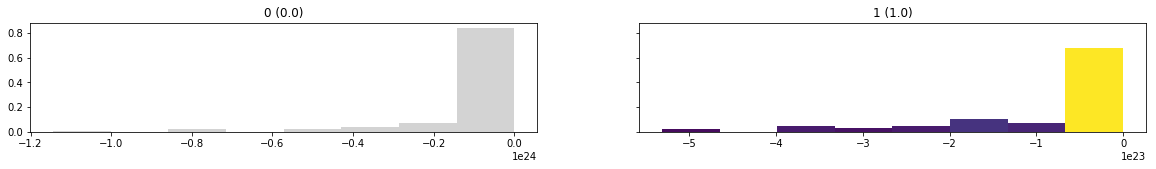

Incorrect :()


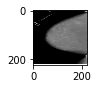

Real:  1


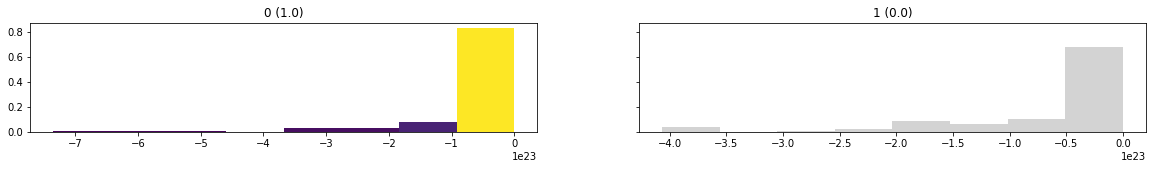

Incorrect :()


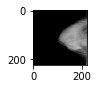

Real:  0


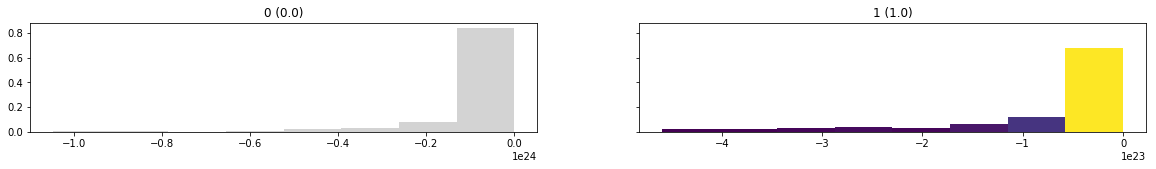

Incorrect :()


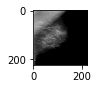

Real:  0


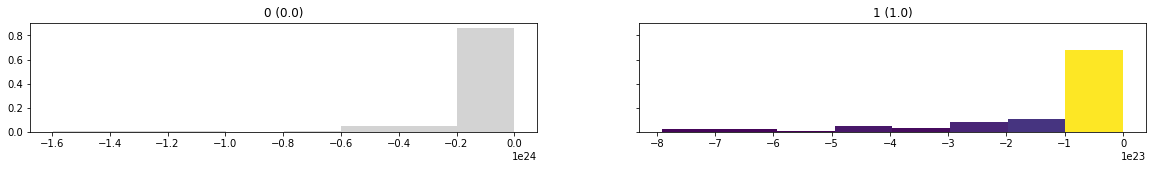

Incorrect :()


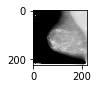

Real:  0


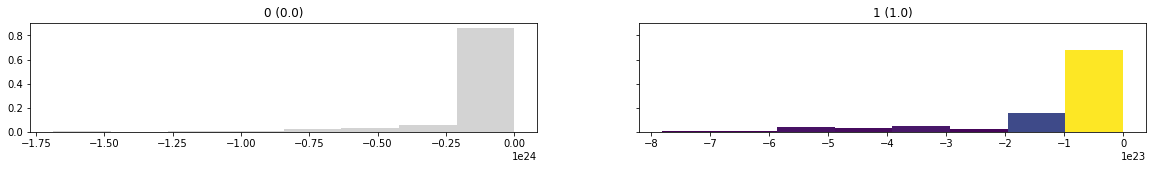

Incorrect :()


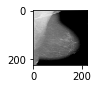

Real:  1


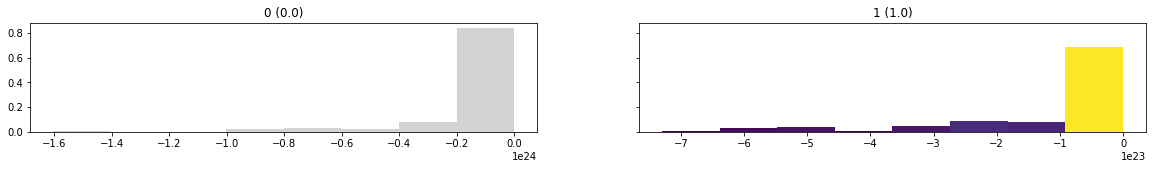

Correct


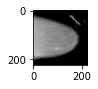

Real:  0


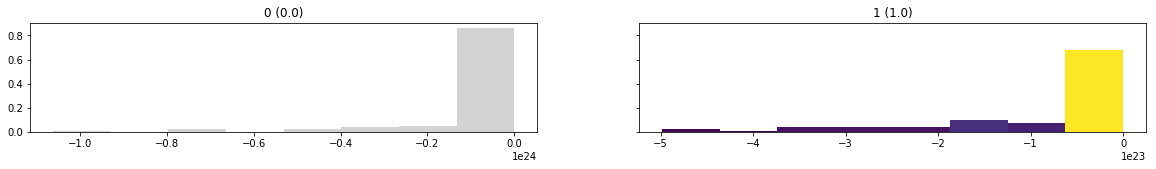

Incorrect :()


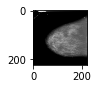

Real:  0


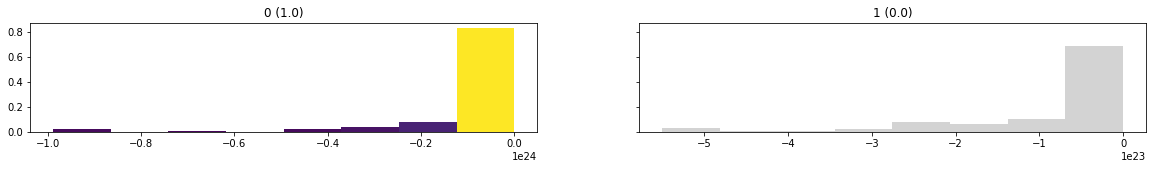

Correct


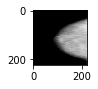

Real:  0


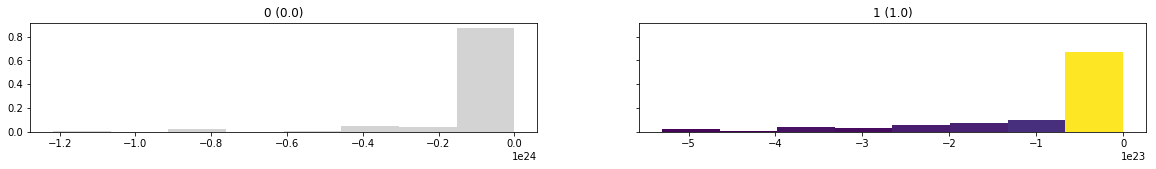

Incorrect :()


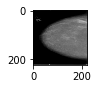

Real:  0


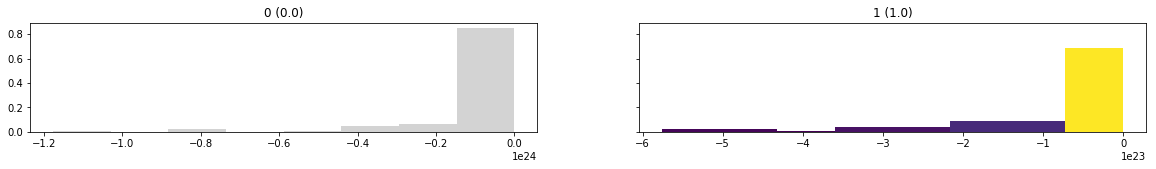

Incorrect :()


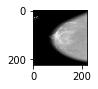

Real:  0


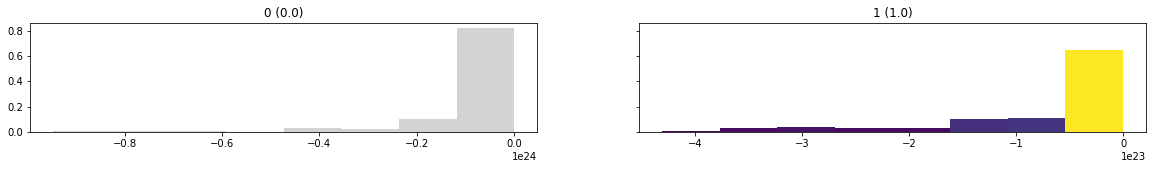

Incorrect :()


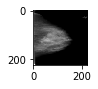

Real:  0


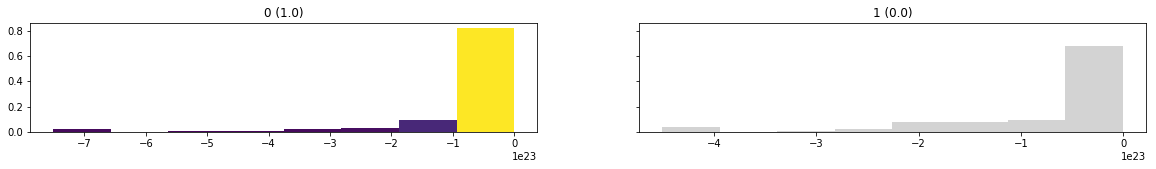

Correct


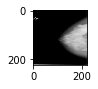

Real:  0


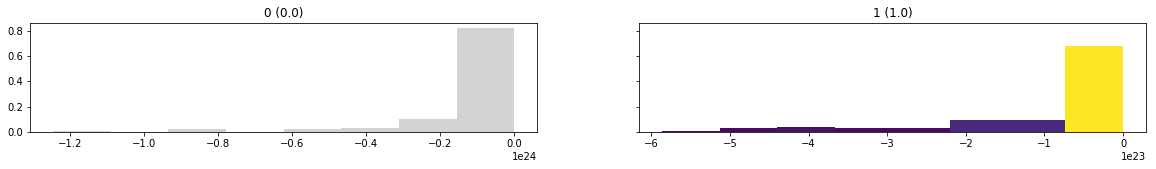

Incorrect :()


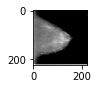

Real:  1


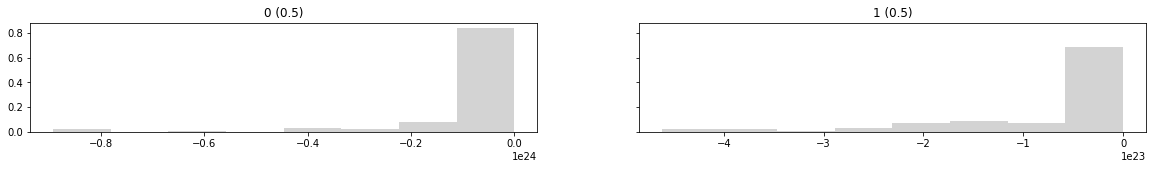

Undecided.


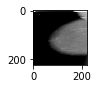

Real:  1


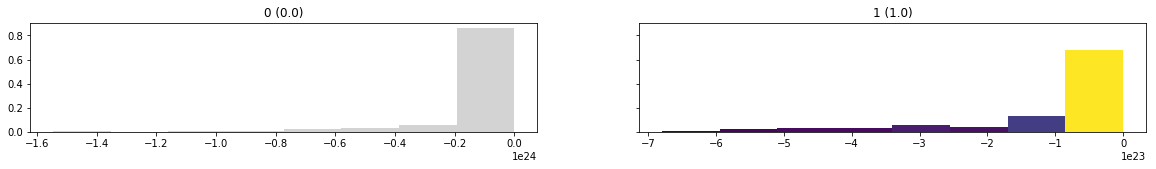

Correct


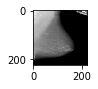

Real:  0


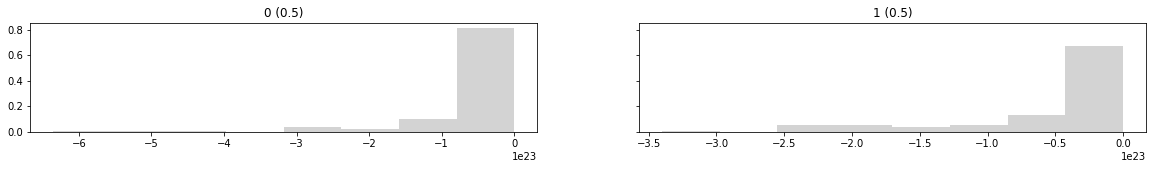

Undecided.


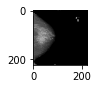

Real:  0


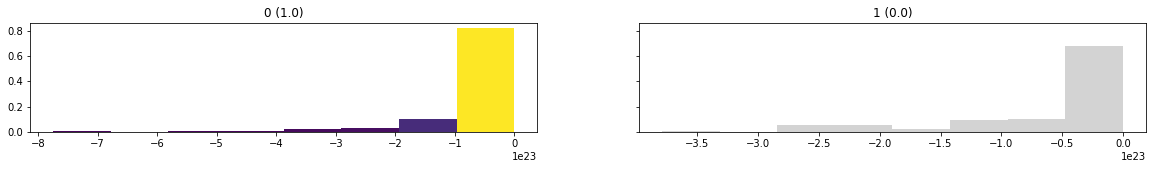

Correct


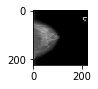

Real:  1


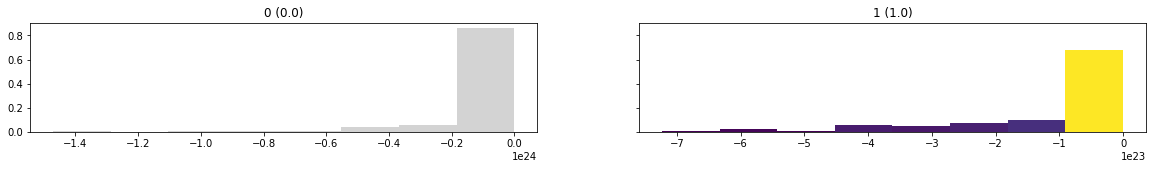

Correct


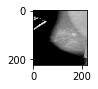

Real:  0


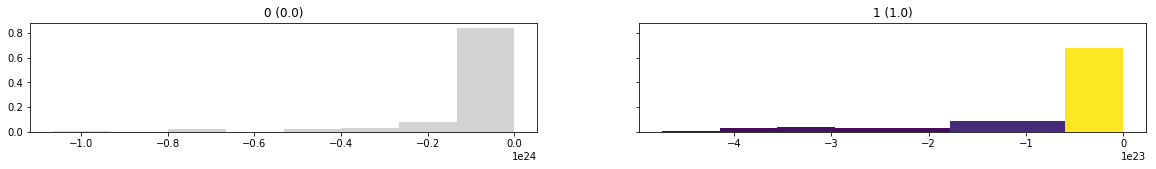

Incorrect :()


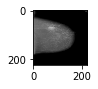

Real:  1


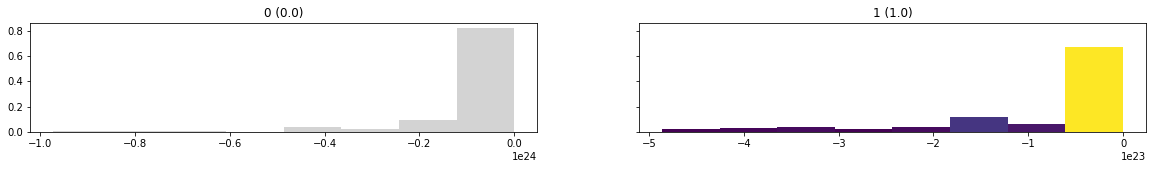

Correct


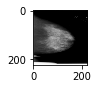

Real:  0


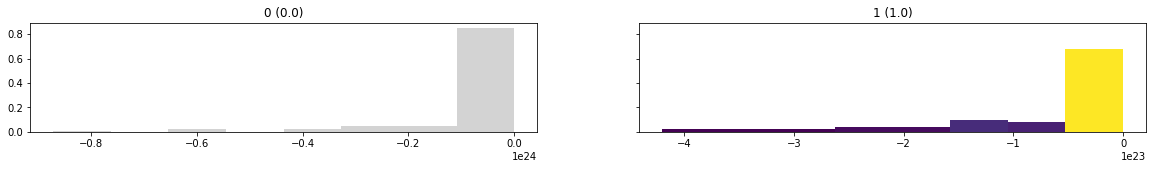

Incorrect :()


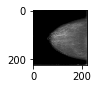

Real:  1


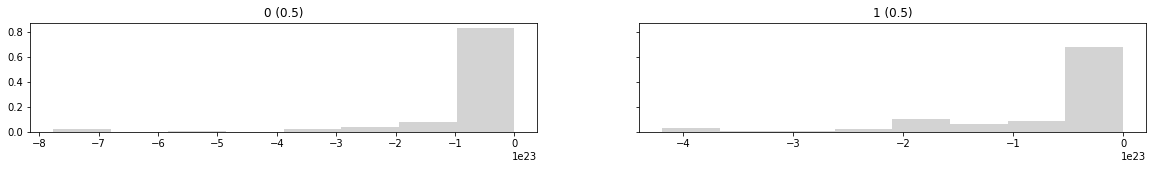

Undecided.


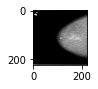

Real:  0


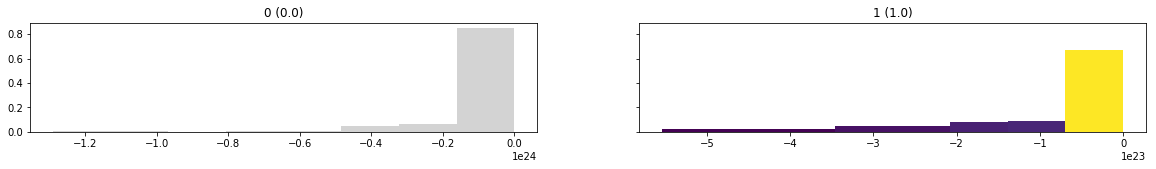

Incorrect :()


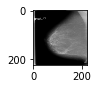

Real:  1


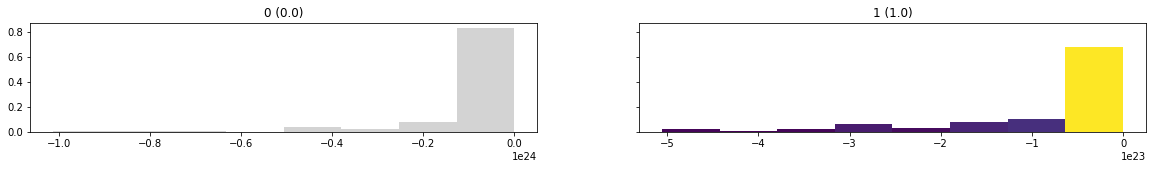

Correct


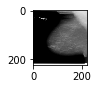

Real:  0


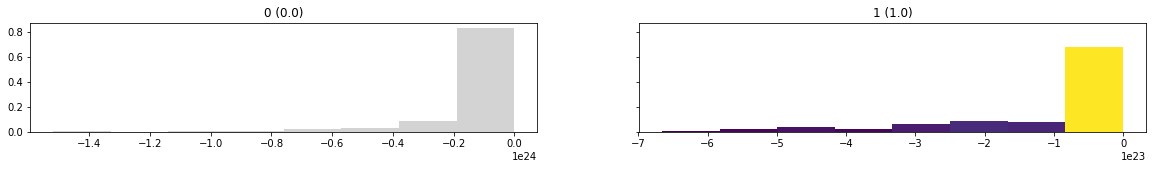

Incorrect :()


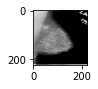

Real:  0


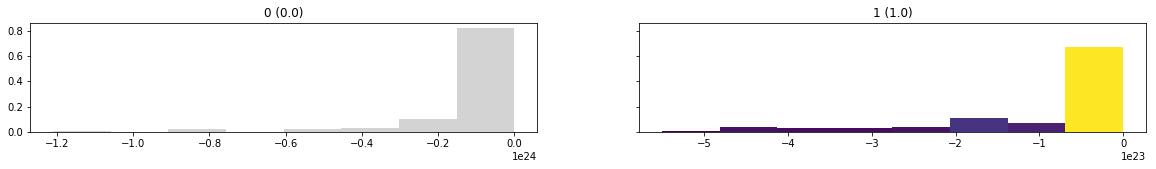

Incorrect :()


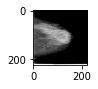

Real:  0


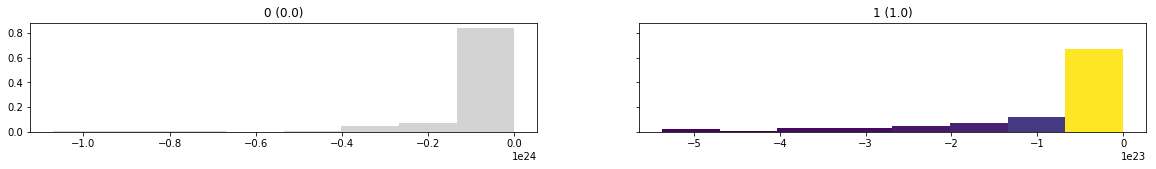

Incorrect :()


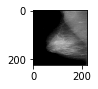

Real:  0


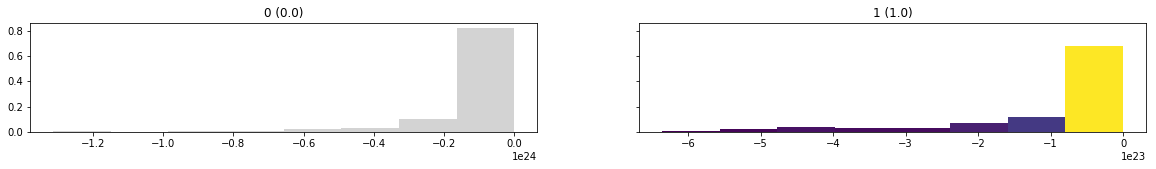

Incorrect :()


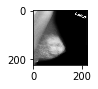

Real:  1


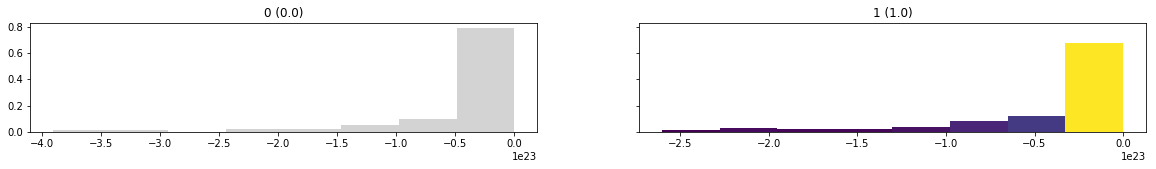

Correct


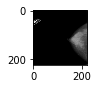

Real:  0


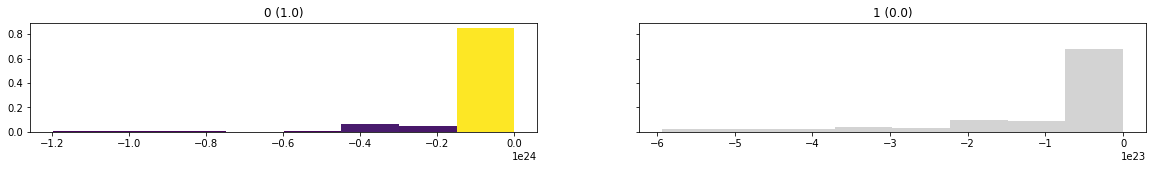

Correct


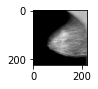

Real:  1


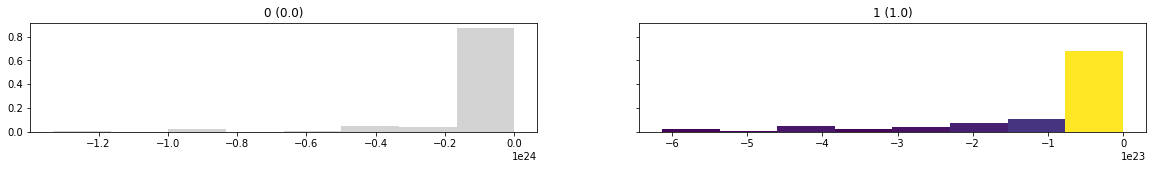

Correct


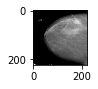

Real:  0


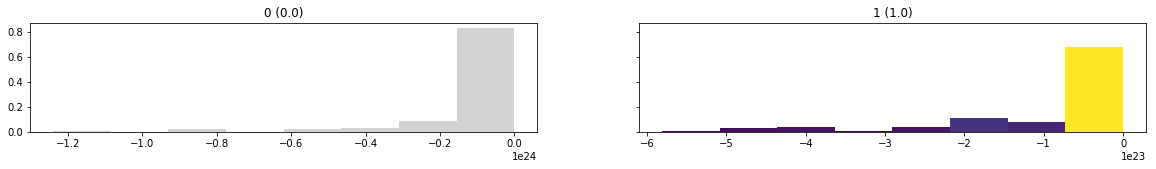

Incorrect :()


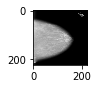

Real:  0


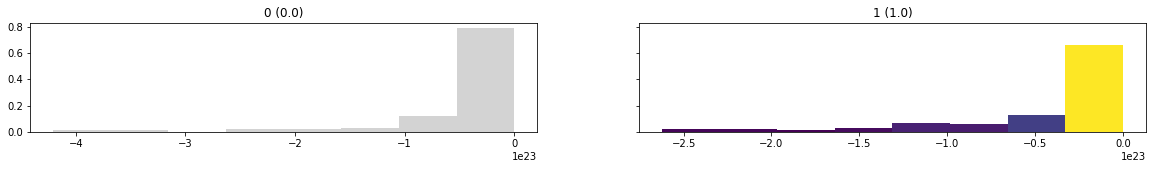

Incorrect :()


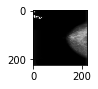

Real:  0


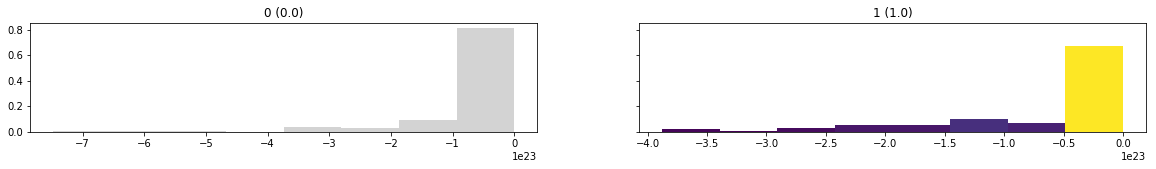

Incorrect :()


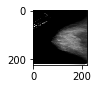

Real:  0


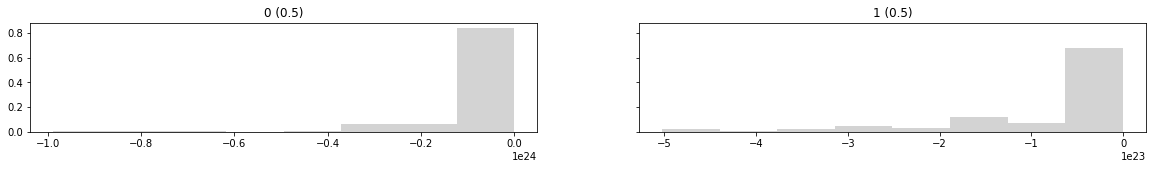

Undecided.


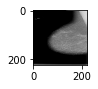

Real:  0


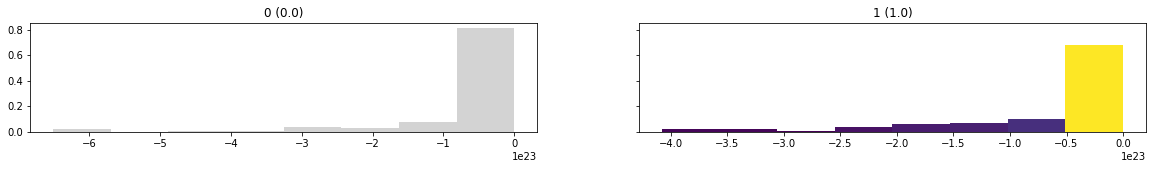

Incorrect :()


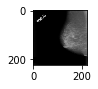

Real:  1


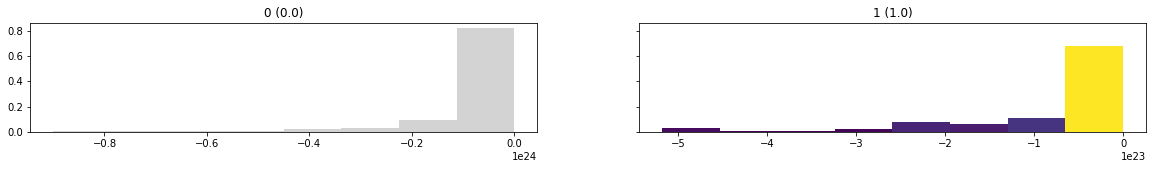

Correct


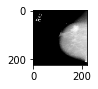

Real:  0


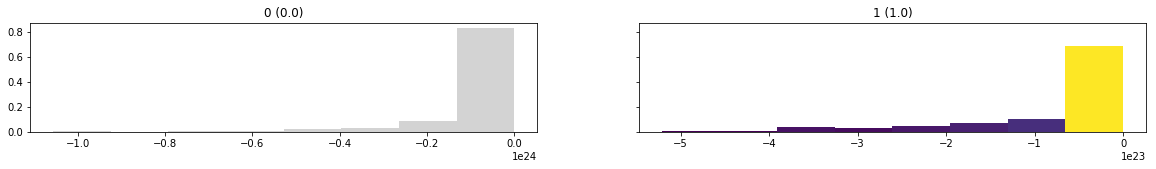

Incorrect :()


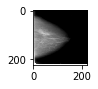

Real:  0


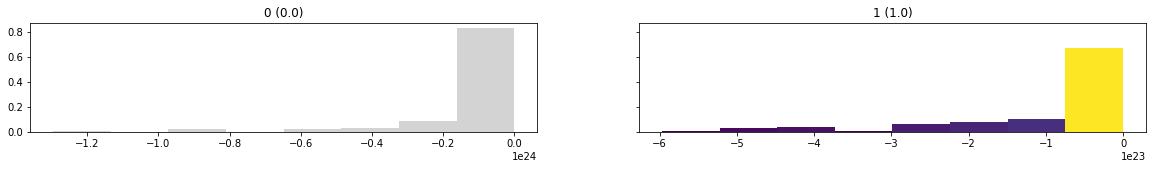

Incorrect :()


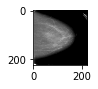

Real:  0


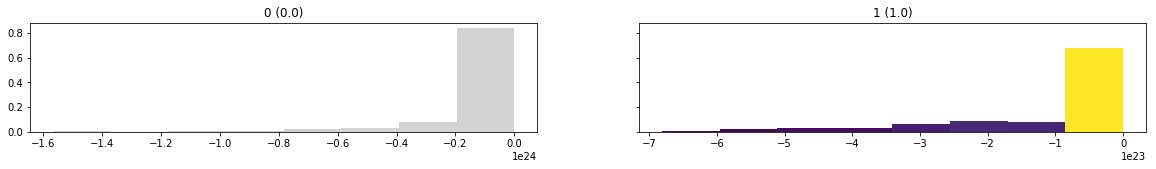

Incorrect :()


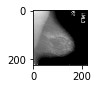

Real:  1


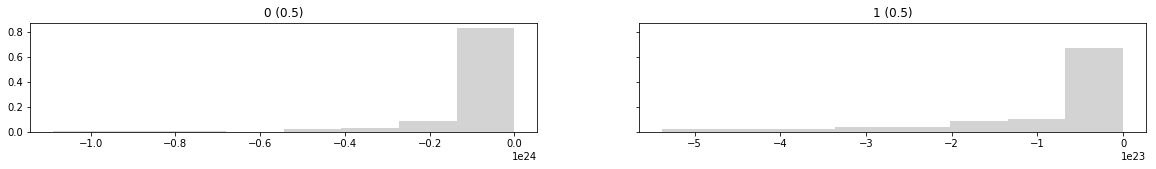

Undecided.


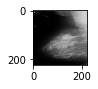

Real:  0


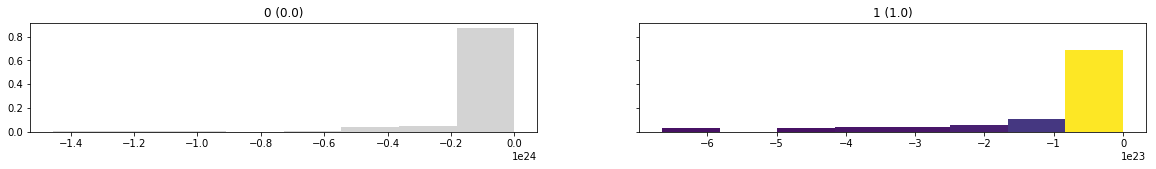

Incorrect :()


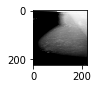

Real:  0


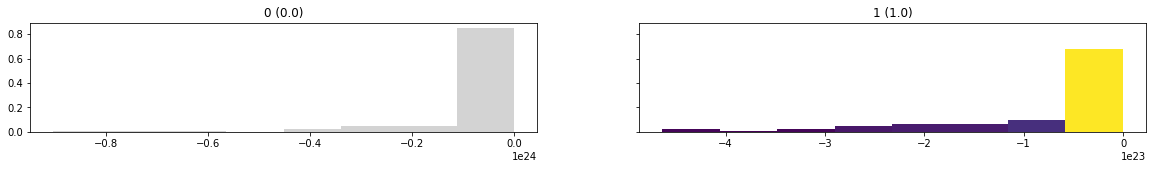

Incorrect :()


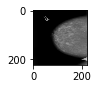

Real:  1


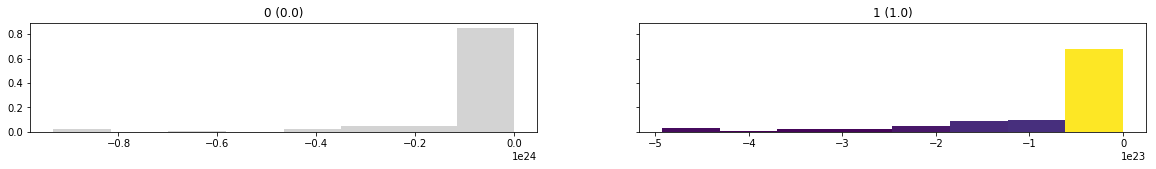

Correct


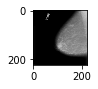

Real:  0


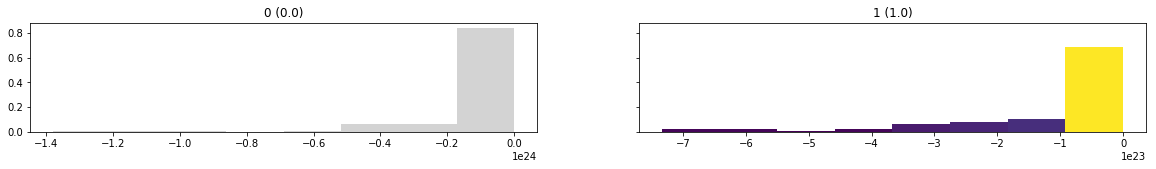

Incorrect :()


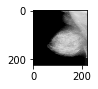

Real:  0


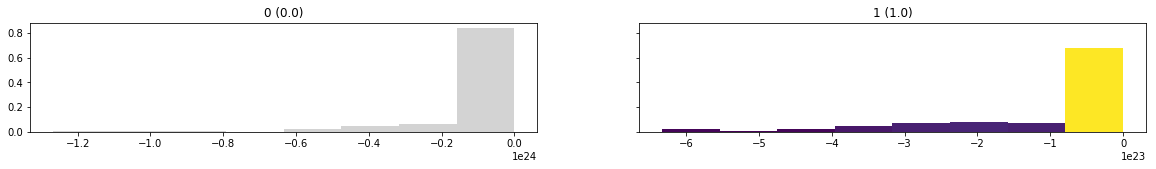

Incorrect :()


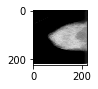

Real:  1


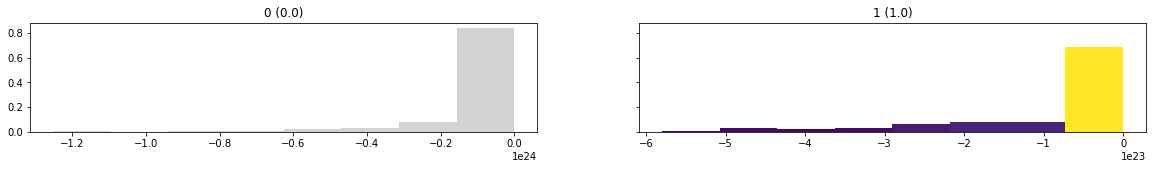

Correct


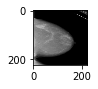

Real:  1


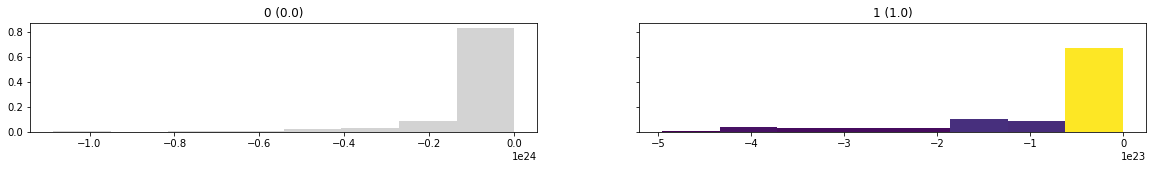

Correct


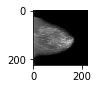

Real:  0


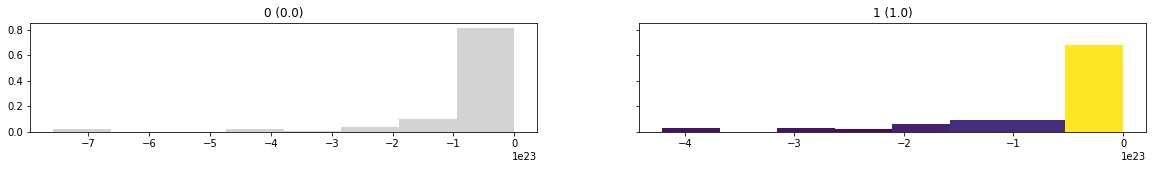

Incorrect :()


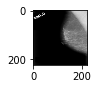

Real:  0


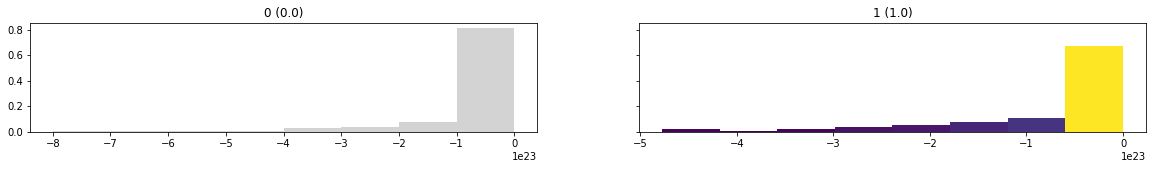

Incorrect :()


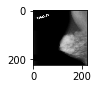

Real:  0


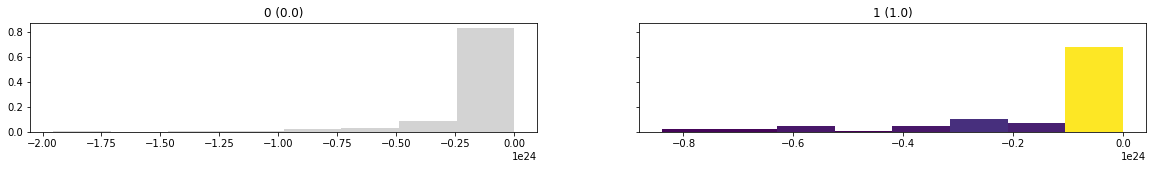

Incorrect :()


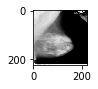

Real:  1


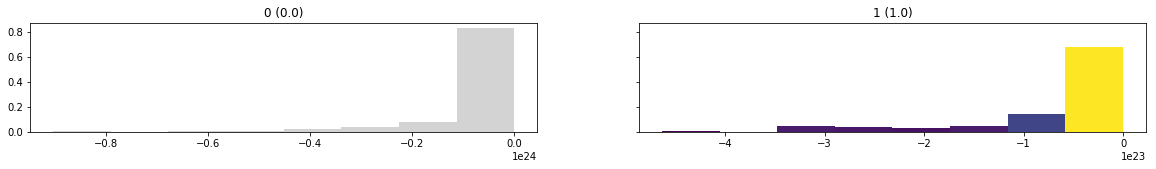

Correct


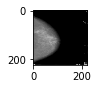

Real:  1


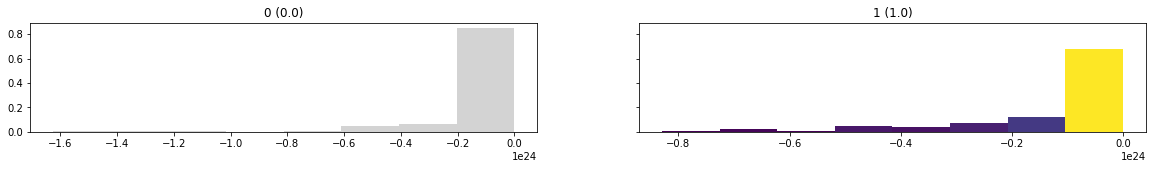

Correct


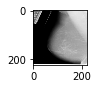

Real:  0


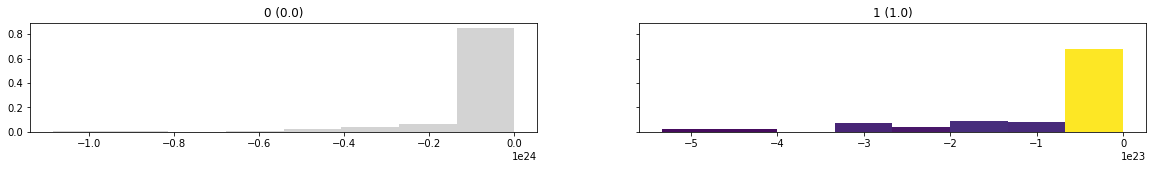

Incorrect :()


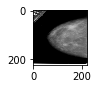

Real:  1


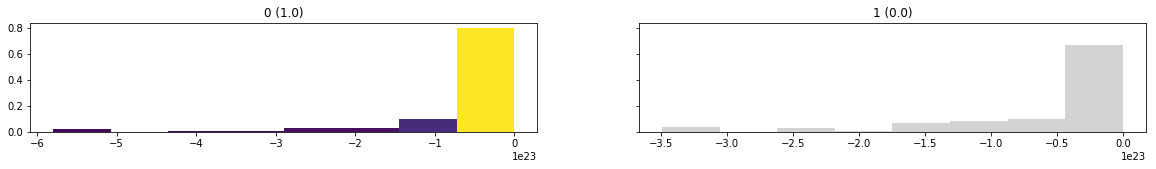

Incorrect :()


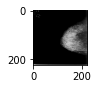

Real:  1


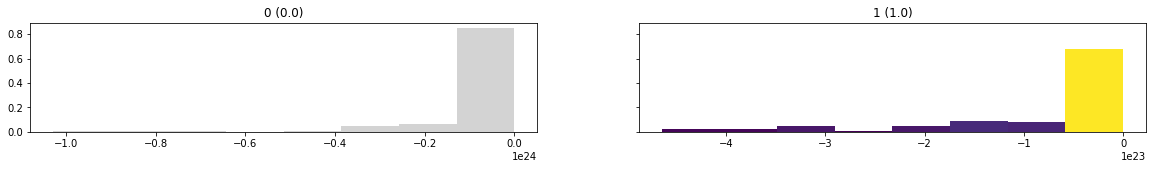

Correct


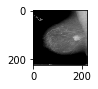

Real:  1


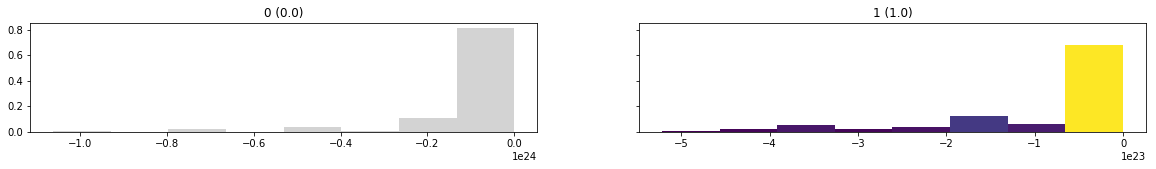

Correct


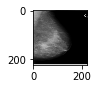

Real:  1


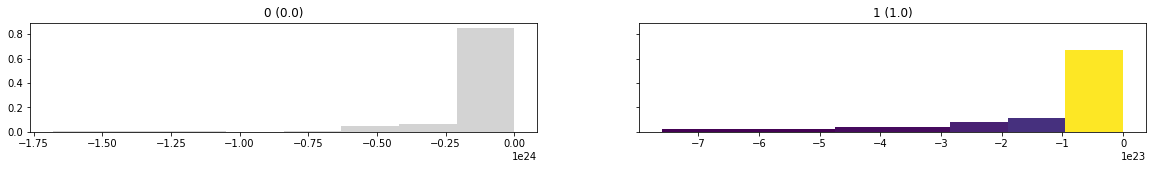

Correct


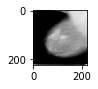

Real:  1


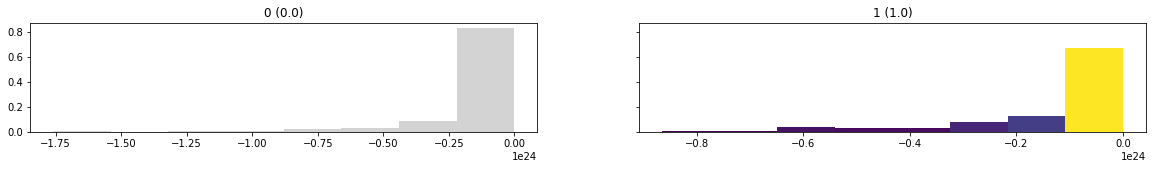

Correct


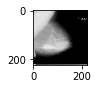

Real:  1


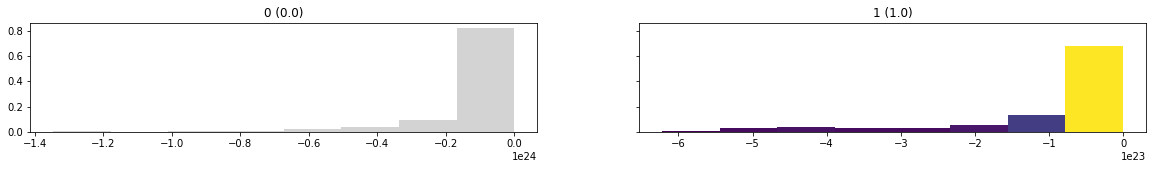

Correct


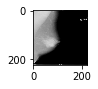

Real:  1


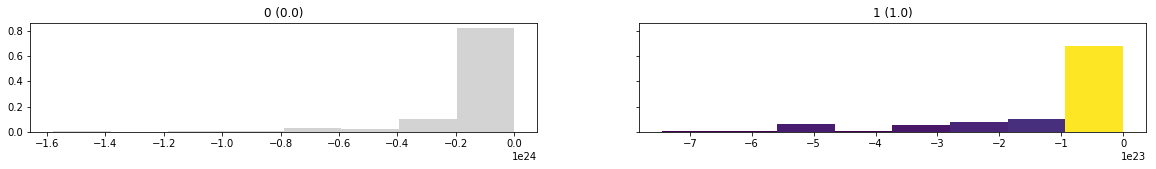

Correct


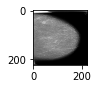

Real:  0


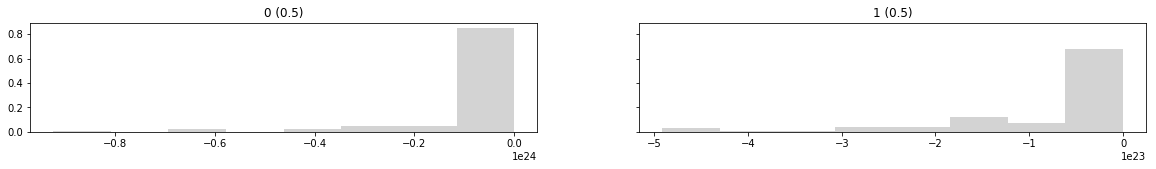

Undecided.


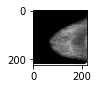

Real:  0


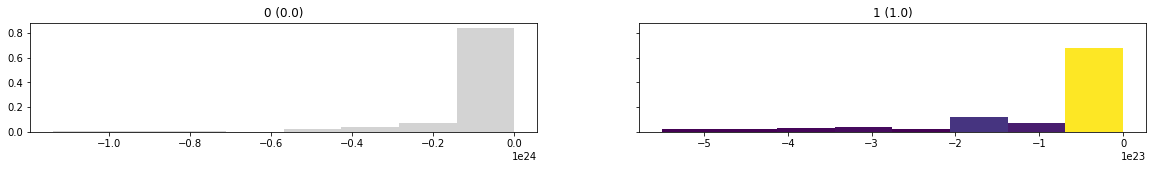

Incorrect :()


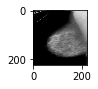

Real:  0


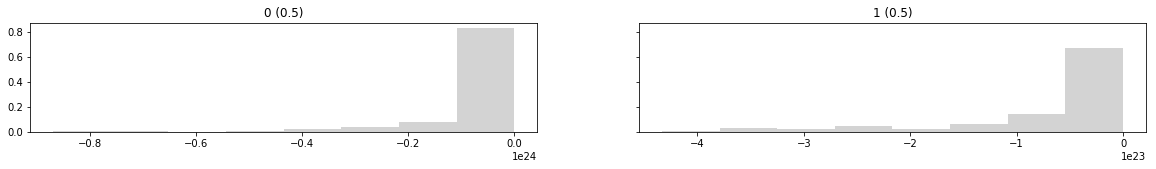

Undecided.


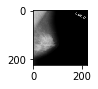

Summary
Total images:  64
Predicted for:  57
Accuracy when predicted:  0.40350877192982454


(64, 23.0, 57)

In [0]:
test_batch(images[:100], labels[:100])